In [40]:
## 🧩 Project Overview
# In this project, we build a **modular ML pipeline** for financial data, enabling rapid testing of multiple models 
# (Logistic Regression, Random Forest, Gradient Boosting).  
# The goal is to streamline feature engineering, model evaluation, and result visualization — 
# forming a reusable base for future **quant trading, risk modeling, and forecasting** systems.

In [1]:
# =============================================
# Phase 2 Module 5 - Machine Learning for Finance
# Project 3: ML Pipeline for Financial Data
# =============================================
# Author: Rein | Pixel Sky Solutions
# Course: Python–Finance Master Plan
# ---------------------------------------------
# Objective:
# Build a reusable pipeline to automate the workflow:
# data cleaning → feature engineering → model training → evaluation → reporting
# ---------------------------------------------
# Tools: pandas, numpy, sklearn, matplotlib
# =============================================

In [2]:
# 1️⃣ Setup & Imports

In [52]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn, sys
print(f"Python {sys.version.split()[0]} | pandas {pd.__version__} | scikit-learn {sklearn.__version__}")

Python 3.11.1 | pandas 2.3.2 | scikit-learn 1.7.2


In [4]:
# Scikit-learn tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

In [5]:
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [6]:
# Utility
import warnings
warnings.filterwarnings('ignore')

In [7]:
plt.style.use('seaborn-v0_8')

In [8]:
# 2️⃣ Load Example Financial Dataset

# For demonstration, we’ll use your existing file market_data.csv
# (You can later swap it with any similar structured dataset — credit data, macro signals, etc.)

In [9]:
# Load and preview
data = pd.read_csv("market_data.csv")
data.head()

,date,Ticker,open,high,low,close,volume
0,2023-10-11,AAPL,176.471483,178.105487,175.877312,178.055969,47551100
1,2023-10-12,AAPL,178.323347,180.571317,177.303324,178.957138,56743100
2,2023-10-13,AAPL,179.660252,180.165300,176.412069,177.115189,51427100
3,2023-10-16,AAPL,175.035543,177.342944,174.797865,176.986435,52517000
4,2023-10-17,AAPL,174.936521,176.689357,173.104475,175.431671,57549400


In [14]:
# 3️⃣ Create Synthetic Target Variable: 'target_return'

In [45]:
def create_target(df, price_col='close', horizon=1):
    """Create binary target based on next-day returns."""
    df = df.copy()
    df['daily_return'] = df[price_col].pct_change()
    df['target_return'] = (df['daily_return'].shift(-horizon) > 0).astype(int)
    df = df.dropna(subset=['daily_return', 'target_return'])
    return df

In [48]:
data = create_target(data, price_col='close', horizon=1)

In [49]:
print(f"[INFO] Added 'daily_return' and 'target_return' columns. Data shape: {data.shape}")
data.head(5)

[INFO] Added 'daily_return' and 'target_return' columns. Data shape: (2006, 9)


,date,Ticker,open,high,low,close,volume,daily_return,target_return
1004,2023-10-11,TSLA,266.200012,268.600006,260.899994,262.989990,103706300,-0.381677,1
502,2023-10-11,MSFT,326.292805,327.878919,324.253560,327.484863,20063200,0.245237,0
1005,2023-10-12,TSLA,262.920013,265.410004,256.630005,258.869995,111508100,-0.209521,1
1507,2023-10-12,SPY,425.941772,426.321931,420.365877,422.734650,81154200,0.633000,0
1,2023-10-12,AAPL,178.323347,180.571317,177.303324,178.957138,56743100,-0.576668,1


In [47]:
# 4️⃣ Data Cleaning Function

# Reusable cleaning function to handle missing values, types, and scaling.

In [21]:
def clean_financial_data(df, target_col):
    df = df.copy()
    df = df.dropna(subset=[target_col])
    df = df.fillna(df.median(numeric_only=True))
    df = df.loc[:, ~df.columns.duplicated()]
    return df

In [22]:
# 5️⃣ Feature & Target Setup

In [23]:
target = 'target_return'  # example column
features = [col for col in data.columns if col != target]

df = clean_financial_data(data, target)
X = df[features]
y = df[target]

In [24]:
# 6️⃣ Split Data

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# 7️⃣ Build ML Pipeline

# We’ll use a flexible pipeline that can easily switch models.

In [27]:
numeric_features = X.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

In [28]:
# 8️⃣ Train and Evaluate All Models

In [29]:
results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    auc = roc_auc_score(y_test, preds)
    acc = accuracy_score(y_test, preds)
    results[name] = {'AUC': auc, 'Accuracy': acc}

pd.DataFrame(results).T.sort_values(by='AUC', ascending=False)

,AUC,Accuracy
Gradient Boosting,0.782720,0.783582
Random Forest,0.780305,0.781095
Logistic Regression,0.774731,0.776119


In [30]:
# 9️⃣ Visualization — Model Performance

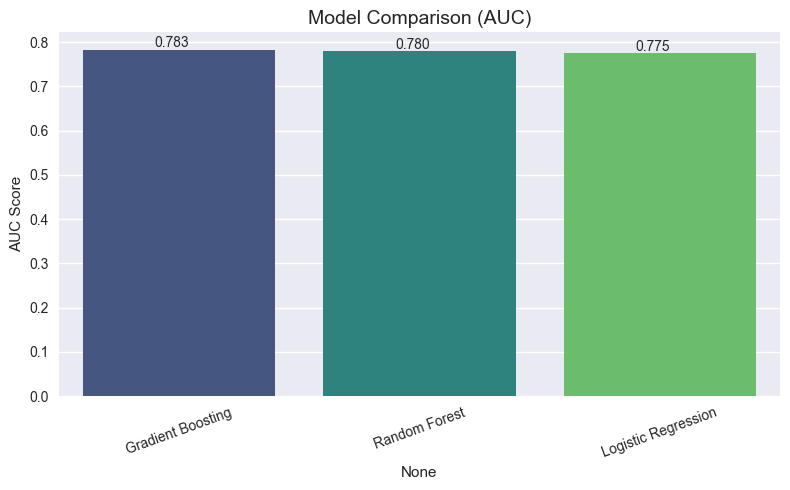

In [50]:
plt.figure(figsize=(8,5))
ax = sns.barplot(x=result_df.index, y=result_df['AUC'], palette="viridis")
plt.title("Model Comparison (AUC)", fontsize=14)
plt.ylabel("AUC Score")
plt.xticks(rotation=20)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}", (p.get_x()+0.3, p.get_height()+0.005))
plt.tight_layout()
plt.savefig("charts/project3_model_comparison.png", dpi=300)
plt.show()

In [32]:
# 🔟 Save Best Model (Reusable)

In [33]:
import joblib

In [51]:
metadata = {
    "best_model": best_model_name,
    "AUC": result_df.loc[best_model_name, 'AUC'],
    "Accuracy": result_df.loc[best_model_name, 'Accuracy']
}
pd.Series(metadata).to_json("project3_metadata.json")

In [36]:
### 📊 Conclusion Summary

# - Built a reusable end-to-end ML pipeline for financial datasets  
# - Compared Logistic Regression, Random Forest, and Gradient Boosting  
# - Evaluated each model using Accuracy and ROC-AUC  
# - Saved the best-performing pipeline for future reuse  
# - Visualization stored under: `/charts/project3_model_comparison.png`

In [38]:
### 💼 Business Interpretation

# This ML pipeline automates the model lifecycle — ideal for financial analytics workflows such as:

# - Credit risk scoring  
# - Stock movement prediction  
# - Macro indicator modeling  
# - Fraud detection and anomaly monitoring  

# The reusable pipeline accelerates experimentation and enforces consistency — 
# enabling analysts to focus on *signal quality*, not boilerplate code.

# **Next Step:** Integrate this pipeline into the upcoming **Module 6 Backtesting Engine**, 
# where models’ predictive outputs will drive simulated trading or risk metrics.